In [126]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import imageio
import cv2
from numpy import pi
from numpy import sin
from numpy import zeros
from numpy import r_
from scipy import signal
from scipy import misc
from scipy import fftpack
import matplotlib.pylab as pylab
from math import ceil
from math import *

In [127]:
#dct and idct
def dct2(a):
    return scipy.fftpack.dct( scipy.fftpack.dct( a, axis=0, norm='ortho' ), axis=1, norm='ortho' )

def idct2(a):
    return scipy.fftpack.idct( scipy.fftpack.idct( a, axis=0 , norm='ortho'), axis=1 , norm='ortho')

Text(0.5, 1.0, 'Baboon')

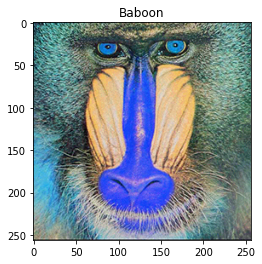

In [128]:
#reading image
img=cv2.imread('baboon256.png')
plt.figure()
plt.imshow(img)
plt.title('Baboon')

(256, 256)


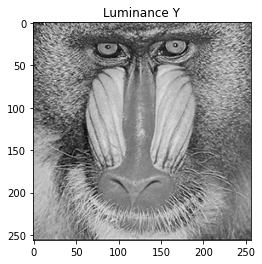

In [129]:
transcol=cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
plt.figure()
plt.imshow(transcol[:,:,0],cmap='gray')
plt.title('Luminance Y')
imgn=transcol[:,:,0]
print(imgn.shape)

filename = 'hostY.png'
cv2.imwrite(filename, imgn)

In [130]:
quant=[[16,11,10,16,24,40,51,61],[12,12,14,19,26,58,60,55],[14,13,16,24,40,57,69,56],[14,17,22,29,51,87,80,62],[18,22,37,56,68,109,103,77],[24,35,55,64,81,104,113,92],[49,64,78,87,103,121,120,101],[72,92,95,98,112,100,103,99]]
arr=np.array(quant,dtype=object)
arr

array([[16, 11, 10, 16, 24, 40, 51, 61],
       [12, 12, 14, 19, 26, 58, 60, 55],
       [14, 13, 16, 24, 40, 57, 69, 56],
       [14, 17, 22, 29, 51, 87, 80, 62],
       [18, 22, 37, 56, 68, 109, 103, 77],
       [24, 35, 55, 64, 81, 104, 113, 92],
       [49, 64, 78, 87, 103, 121, 120, 101],
       [72, 92, 95, 98, 112, 100, 103, 99]], dtype=object)

Text(0.5, 1.0, 'After IDCT')

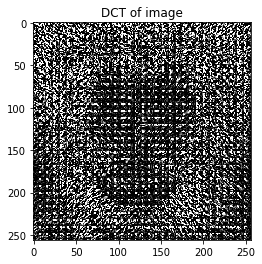

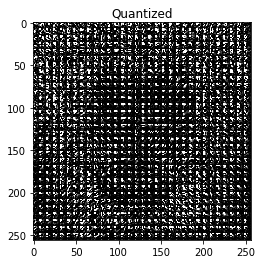

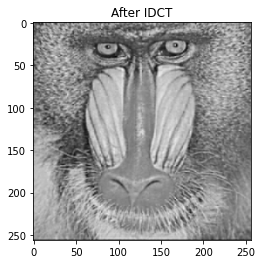

In [131]:
imsize = imgn.shape
dct = np.zeros(imsize)
for i in r_[:imsize[0]:8]:
    for j in r_[:imsize[1]:8]:
        dct[i:(i+8),j:(j+8)] = dct2( imgn[i:(i+8),j:(j+8)] )
plt.figure()
plt.imshow(dct,cmap='gray',vmax = np.max(dct)*0.01,vmin = 0)
plt.title( "DCT of image")

blocks=[]
for r in range(imgn.shape[0]//8):  # loop vertically
    for c in range(imgn.shape[1]//8):  # loop horizontally
        block = dct[r*8:(r+1)*8, c*8:(c+1)*8]
        for i in range(0,8):
            for j in range(0,8):
                x=block[i][j]/arr[i][j]
                block[i][j]=x
        dct[r*8:(r+1)*8, c*8:(c+1)*8]=block
        blocks.append(block)

plt.figure()
plt.imshow(dct,cmap='gray',vmax = np.max(dct)*0.01,vmin = 0)
plt.title( "Quantized")
imsize = dct.shape
idct = np.zeros(imsize)
for i in r_[:imsize[0]:8]:
    for j in r_[:imsize[1]:8]:
        idct[i:(i+8),j:(j+8)] = idct2( dct[i:(i+8),j:(j+8)] )
plt.figure()
plt.imshow(idct,cmap='gray')
plt.title( "After IDCT")

(32, 32)


Text(0.5, 1.0, 'Watermark')

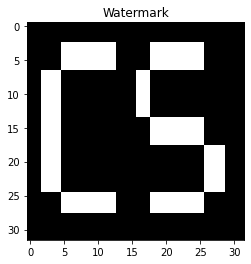

In [132]:
img_grey = cv2.imread('watermark.jpeg', cv2.IMREAD_GRAYSCALE)
thresh = 128
img_binary = cv2.threshold(img_grey, thresh, 255, cv2.THRESH_BINARY)[1]
plt.figure()
plt.imshow(img_binary,cmap='gray',vmax = np.max(dct)*0.01,vmin = 0)
print(img_binary.shape)
plt.title( "Watermark")

(32, 32)


Text(0.5, 1.0, 'Watermark scrambled')

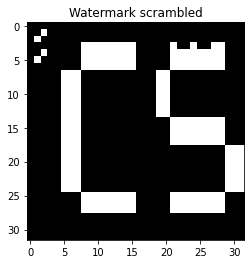

In [133]:
k=7
m=3
for i in range(0,32):
    for j in range(0,32):
        i_new,j_new=0,0
        mat_1=np.array([[1,1],[k,k+1]])
        temp2=np.array([[i%m],[j%m]])
        p=mat_1@temp2
        i_new=p[0][0]
        j_new=p[1][0]
        temp=img_binary[i][j]
        img_binary[i][j]=img_binary[i_new][j_new]
        img_binary[i_new][j_new]=temp
plt.figure()
plt.imshow(img_binary,cmap='gray',vmax = np.max(dct)*0.01,vmin = 0)
print(img_binary.shape)
plt.title( "Watermark scrambled")

In [134]:
def C_star(g,block,i,j):
  m=30
  c_=0
  C=block[i][j]
  r=abs(C)%m
  q=abs(C)/m
  sign=0
  if(C>=0):
    sign=1
  else:
    sign=-1
  if(g==0):
    r_=m/4
    c_low=sign*(q*m+r_)
    c_high=sign*((q+1)*m+r_)
    if(abs(c_low-C)<=abs(c_high-C)):
      c_=c_low
    if(abs(c_low-C)>abs(c_high-C)):
      c_=c_high
  if(g==1):
    r_=(3*m)/4
    c_low=sign*((q-1)*m+r_)
    c_high=sign*(q*m+r_)
    if(abs(c_low-C)<=abs(c_high-C)):
      c_=c_low
    if(abs(c_low-C)>abs(c_high-C)):
      c_=c_high
  return c_

True

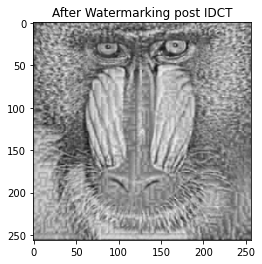

In [135]:
C_loc=[[0,1], [0,2], [0,3], [1,0], [1,1], [1,2], [2,0], [2,1], [3,0]]
record_=[]
d,e=0,0
count=0
blocks=np.array(blocks)
for i in range(0,32):
  for j in range(0,32):
    g=0 if img_binary[i][j]==0 else 1
    s=99999999
    for k in C_loc:
      if(blocks[count][k[0]][k[1]]<s):
        s=blocks[count][k[0]][k[1]]
        d=k[0]
        e=k[1]
    c=C_star(g, blocks[count], d, e)
    # print(d,e)
    record_.append([d,e])
    blocks[count][d][e]=c
    count+=1
count=0
for r in range(imgn.shape[0]//8):
    for c in range(imgn.shape[1]//8):
        dct[r*8:(r+1)*8, c*8:(c+1)*8]=blocks[count]
        count+=1
imsize = dct.shape
idct = np.zeros(imsize)
for i in r_[:imsize[0]:8]:
    for j in r_[:imsize[1]:8]:
        idct[i:(i+8),j:(j+8)] = idct2( dct[i:(i+8),j:(j+8)] )
plt.figure()
plt.imshow(idct,cmap='gray')
plt.title( "After Watermarking post IDCT")
result = cv2.normalize(idct, dst=None, alpha=0, beta=255,norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
filename = 'Watermarked.png'
cv2.imwrite(filename, result)

In [136]:
# print(idct.shape)


# D=imgn-idct
# f=0.75
# imgnn=idct+f*D
# idct=imgnn

# plt.figure()
# plt.imshow(idct,cmap='gray')
# plt.title('Weighted Correction')

Text(0.5, 1.0, 'Extracted watermark')

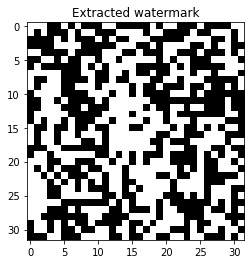

In [137]:
#extraction of watermark from post idct image after watermarking
new_img=idct
imsize = new_img.shape
dct_watermark = np.zeros(imsize)
for i in r_[:imsize[0]:8]:
    for j in r_[:imsize[1]:8]:
        dct_watermark[i:(i+8),j:(j+8)] = dct2( new_img[i:(i+8),j:(j+8)] )
        #scaling
        dct_watermark[i:(i+8),j:(j+8)][2][0]+=2
        dct_watermark[i:(i+8),j:(j+8)][0][2]+=2
attacked_idct=np.zeros(imsize)
for i in r_[:imsize[0]:8]:
    for j in r_[:imsize[1]:8]:
        attacked_idct[i:(i+8),j:(j+8)] = idct2( dct_watermark[i:(i+8),j:(j+8)] )

result = cv2.normalize(attacked_idct, dst=None, alpha=0, beta=255,norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
filename = 'Watermarked_modified.png'
cv2.imwrite(filename, result)

h=0
imsize = dct_watermark.shape
extracted_watermark = []
dct_watermark=dct
for r in range(dct_watermark.shape[0]//8):
    for c in range(dct_watermark.shape[1]//8):
        b=dct_watermark[r*8:(r+1)*8, c*8:(c+1)*8]
        value=b[record_[h][0]][record_[h][1]]
#         print(record_[h][0],record_[h][1])
        h=h+1
        val=abs(value)%5
        if(val<2.5):
          extracted_watermark.append(0)
        else:
          extracted_watermark.append(255)
# print(extracted_watermark)
new_watermark_extracted=np.zeros((32,32))
h=0
for l in range(0,32):
  for p in range(0,32):
    new_watermark_extracted[l][p]=extracted_watermark[h]
    h=h+1
# print(np.count_nonzero(np.array(img_binary)))
# print(np.count_nonzero(new_watermark_extracted))
plt.figure()
plt.imshow(new_watermark_extracted,cmap='gray')
plt.title( "Extracted watermark")


In [138]:
count_1=0
count_2=0
l=0
for i in range(0,32):
  for j in range(0,32):
    if(new_watermark_extracted[i][j]==img_binary[i][j]):
      count_1+=1
    else:
      count_2+=1
res=(abs(count_1-count_2))/1024
print("µ:",round(res,4))

µ: 0.0684
